**Student Name**: Maksim Karnaukh
    
**Student ID**: 20201604

# Lab session 7

This lab session is introduction to Deep Reinforcement Learning(DRL). 
In this notebook, you'll be asked to build:-
* a naive DQN
* DQN with experience replay
* DQN with target networks
* Improvements on DQN

### What is DQN?

DQN is the first deep reinforcement learning method proposed by DeepMind in year 2015. Introduction to *Deep Neural networks* introduced in *Lab session 6* act as feature extractor for our agent. 

A DQN, or Deep Q-Network, approximates a state-value function in a Q-Learning framework with a neural network. In the Atari Games case, they take in several frames of the game as an input and output state values for each action as an output. 

Training on Atari games is often **time** and **resource** consuming. We'll train a DQN agent on simpler environments like cartpole to develop basic practicalities.
However by the end of the lab session we'll try to train an agent to play **PONG**. 

DQN it overcomes unstable learning by mainly 4 techniques:
>* Experience Replay.
>* Target Network.
>* Clipping Rewards.
>* Skipping Frames. 

#### Cart pole

The task is simple, your agent should learn to balance the stick on a platform, without explicitly knowing about law of physics ;)

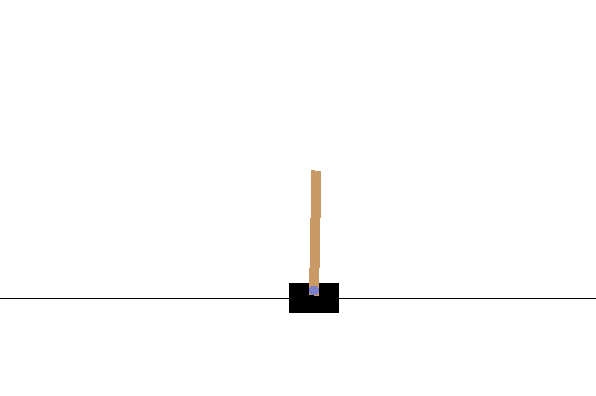

The agent can move platform only left or right.

For more details: https://gym.openai.com/envs/CartPole-v0/.
Optinally you can go through https://github.com/openai/gym/wiki/CartPole-v0 to understand the state space, action space, dynamics and reward function..



#### Note:-
Please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).


If you can get a GPU (jupyterhub/colab) it will be faster. **Otherwise each run cell should take around 2 minutes max.**

In the last part with Atari, the run times are then much longer. **Run once to show sign of life (expected around 15min).** Don't wait for it too long; we will adjust.

In [172]:
import math, random

import cv2
import gym
import numpy as np
from collections import deque

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from torchviz import *

In [173]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

##### Declaring your environment

In [175]:
env_id = "CartPole-v0"
env = gym.make(env_id)

#### Epsilon greedy exploration
I'm sure you know the importance of epsilon. 
we are gonna plot the decay and you can see how it will behave for 10000 steps

In [176]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

<span style="color:blue"> **TODO** </span> Generate the epsilon decay plot.

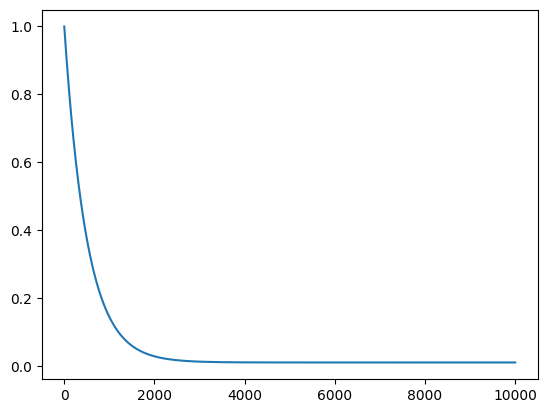

In [177]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

<span style="color:red"> **TODO** </span>  Why do we need decaying epsilon? Explain briefly.

Lots of exploration at first to generate all types and behaviors and observe rewards; then we stay closer to the found optimal path

(Note: the explanation above was not written by me but was already present in the downloaded notebook. It is however generally correct.)

## 1. <span style="color:green"> (7 points) </span> Working our way up to DQN 

### 1.0. Q-value Visualization
Throughout this lab, we will be learning Q functions for the Cartpole problem. In order to increase our understanding of what is happening during the algo, we can try to visualize the Q function during learning, similar to what we were doing in the tabular setting.

In order to achieve this, we first need to understand our state space - according to [the github](https://github.com/openai/gym/blob/103b7633f564a60062a25cc640ed1e189e99ddb7/gym/envs/classic_control/cartpole.py), the observation is 
```
Type: Box(4)
Num     Observation               Min                     Max
0       Cart Position             -4.8                    4.8
1       Cart Velocity             -Inf                    Inf
2       Pole Angle                -0.418                  0.418
3       Pole Angular Velocity     -Inf                    Inf
```
In other words, the observation is a vector $s\in\mathbb{R}^4$ with $s=\left(x_\text{cart}, \dot{x_\text{cart}}, \theta, \dot\theta\right)$


Note that the two most important metrics here are the Pole Angle $\theta$ and Pole Anglar velocity $\dot{\theta}$ - the Cart information is slightly less informative on the relevant task. We know from the doc that $\theta \in \left[ -0.418, 0.418 \right]$; after a bit of testing, we can observe that generally $\dot\theta \in \left[ -2.5, 2.5 \right]$.

If we assume the Cart is in position 0 (center) with velocity 0 (immobile), we can visualize the estimated Q value over the whole (pole angle, pole velocity) space! We simply need to discretize the state space into a 2D $s=\left(\theta, \dot\theta\right)$ grid, with $n$ cells in each dimension.

Note that $\theta$ is the angle of the pole *in radians*, i.e. going counterclockwise, which is a little counter-intuitive with respect to the final plot. Instead, we switch theta around and decide that positive thetas are on the right, while negative thetas are on the left; same for thetadot.

In [178]:
def visualize_q_pi(net, n_samples=15):
    thetas = torch.linspace(-0.418, 0.418, n_samples)
    thetadots = torch.linspace(-2.5, 2.5, n_samples)
    pairs = np.array([[-theta,-thetadot] for thetadot in thetadots 
                                         for theta in thetas])
    states = torch.Tensor([[0,0,theta,thetadot] for theta, thetadot in pairs])
    q_values = net(states).reshape(n_samples,n_samples,2)
    maxq, policy = q_values.max(-1) # returns max, argmax
    policy = policy.detach().numpy().astype(str)
    policy[policy=='0'] = u'←'
    policy[policy=='1'] = u'→'
    maxq = maxq.detach().numpy()
    fig, ax = plt.subplots()
    im = ax.imshow(maxq)
    ax.set_title("Q function and Policy visualization")
    fig.tight_layout()
    plt.colorbar(im)
    for i in range(n_samples):
        for j in range(n_samples):
            text = ax.text(j, i, policy[i,j],
                               ha="center", va="center", color="w", fontsize=10)

    span = [0,4,7,10,14]# np.arange(0,n_samples,n_samples//5 +1)
    plt.xticks(span, np.around(thetas[span].numpy(), 2))
    plt.yticks(span, np.around(thetadots[span].numpy(), 2))
    plt.xlabel("theta")
    plt.ylabel("theta dot")
    plt.show()

### 1.1. <span style="color:blue"> **TODO** </span>  Naive Deep Q-Network

##### Useful Reminders and details
*Loss function’s done signal*
*QLearning* used so far used **target $r + \gamma*\max_{a’} Q(s’,a’)$**.

When $s^\prime$ is a terminal state, we know by construction that $Q(s^\prime, \cdot )=0$. 
Until now, we initialized our Q estimates at 0, so this was verified. However, our network will be initialized randomly, so it will most likely not give a 0 value to terminal states. Note that we do never update a terminal state (learn from a s=terminal, s’=?? Transition), therefore we cannot learn this. In order to incorporate this
information, the learn method takes in the `done` signal, which is a boolean indicating whether next_state is a terminal state.
Do not forget to use this signal in the computation of the *expected_q_value*, or the agent will rely on wrong estimates of the terminal state values!

##### Building the Network with PyTorch
- In `__init__`: Use `layer = nn.Linear(n_input, n_output)` to generate a Fully Connected (Linear) layer with the corresponding number of inputs and outputs. We want two hidden layers of size 128.
- In `forward`: Use the layers you have build to generate your network's output. Each hidden layer pass is followed by an [activation function](https://en.wikipedia.org/wiki/Activation_function); we choose ReLU (`F.relu(x)`). Be careful not to apply an activation function on the output! Not only is it useless for the network since it doesn't participate in the Universal Function Approximator Theorem, it will hurt your agent, since the $Q$ value outputs in $\mathbb{R}$ while, for example, ReLU outputs in $\mathbb{R}^+$ and tanh outputs in $]-1,1[$.

<span style="color:blue"> **TODO** </span> 
- Build the network following the requirements above.
- In `act`: under proba epsilon, return a random action; under proba 1-$\epsilon$, extract the Q value from the net so we can $\arg\max$ over it.

In [179]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        self.num_inputs = num_inputs
        self.num_actions = num_actions
        # DONE:
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)
        
    def forward(self, x):
        # DONE:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0].numpy().tolist() # argmax over actions
        else:
            action = random.randint(0, self.num_actions-1)
        return action

In [180]:
model_base = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_base = model_base.cuda()
    
optimizer = optim.Adam(model_base.parameters())

Let's visualize the randomly initialized Q function!

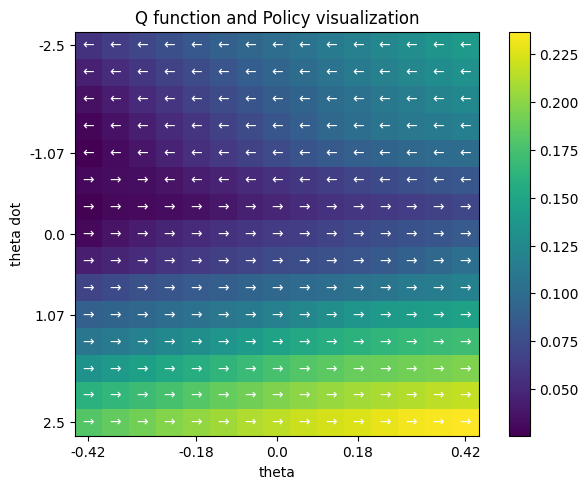

In [181]:
visualize_q_pi(model_base)

#### Computing Temporal Difference Loss

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [182]:
def compute_td_loss_dqn(state, action, reward, next_state, done):
    """
    Parameters
    ----------
    state: numpy array
        current state of env
    action: int
        action you take in env
    reward: int
        reward for the action
    next_state: numpy array
        next state given current state and action
    done: bool
        if it's end of the episode.
    
    Returns
    -------
    loss: 1d-tensor

    """
    # converting variables to tensors
    state = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))  
    action = Variable(torch.from_numpy(np.array(action)))
    reward = Variable(torch.from_numpy(np.array(reward))).float()
    done = Variable(torch.from_numpy(np.array(int(done))))
    # DONE:- predict q_values
    q_values = model_base.forward(state)
    
    # DONE:- predict q_values of next state
    next_q_values = model_base.forward(next_state)
    
    # DONE:- get corresponding action's q-value from predicted q-values
    # hint:- there is a very optimal and good way to do this tensor operations check (gather)
    q_value = q_values[action.item()]
    
    next_q_value = next_q_values.max(0)[0]
    
    # DONE:- calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    # DONE:- calculate MSE for back propagation of loss
    # Hint:- you can't do an operation between a tensor and int. keep an eye on your variable type ;).
    loss = F.mse_loss(q_value, expected_q_value.detach())
    
    # back propagating your loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [183]:
def plot(frame_idx, rewards, losses):
    """
    Parameters
    ----------
    frame_idx: int
        frame id
    rewards: int
        accumulated reward
    losses: int
        loss
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    

<span style="color:blue"> **TODO** </span> Simply run the cell.

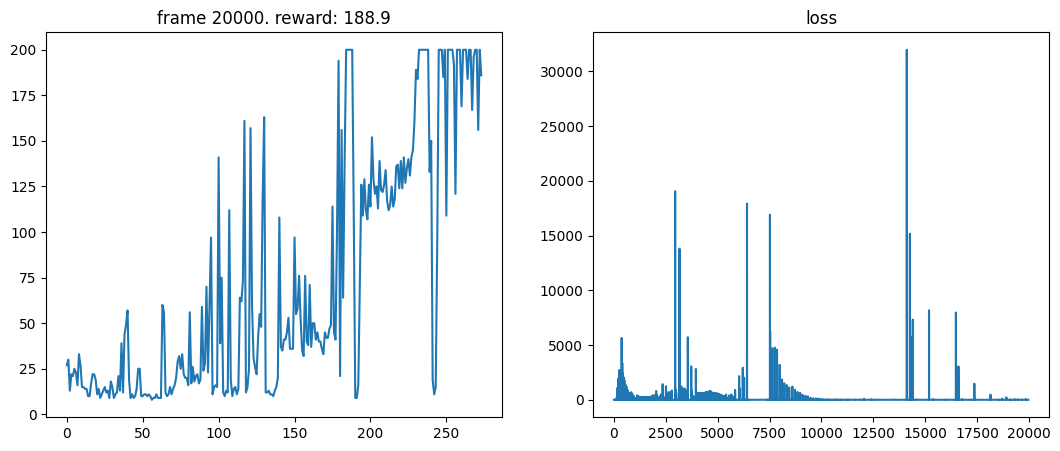

In [184]:
# Reinit
model_base = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_base = model_base.cuda()
    
optimizer = optim.Adam(model_base.parameters())

num_frames = 20000
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0
t = 0
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model_base.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)     
    
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        loss = compute_td_loss_dqn(state, action, reward, next_state, done)
        losses.append(loss.item())
    
    state = next_state
    episode_reward += reward
    t += 1
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

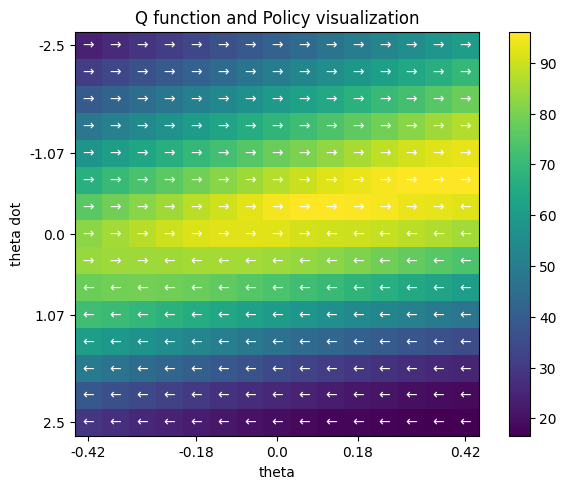

In [185]:
visualize_q_pi(model_base)

<span style="color:red"> **TODO** </span>  Interpret briefly your results.

Here, we work with a Naive Deep Q-Network. We can see that for a long time, the loss stays quite high (averages quite high until frame 10000 roughly, with also quite a few spikes overall) and the reward is quite low and fluctuates a lot (because we explore a lot). The reward increases slowly until at the end it comes to around 200 with a low loss (minus a spike or two). This is a sign that the network is learning a little bit, but it is not very stable and quite slow. 

The learned policy is not the best, but decent, as we can see from the visualization of the Q function. We would like to go to the center point as much as possible, meaning an angle and angle speed of 0. Since we can only go left or right, we would like to go right when the angle speed is negative and left when the angle speed is positive. If the angle speed is around 0, we would like to go right if the angle is negative and left if the angle is positive (note that the further we go away from 0 w.r.t. angle speed, the more the first rule applies). This is what we see in the visualization, but it is not perfect.

### 1.2. Deep Q-Network with Replay buffer

#### Experience Replay

Experience replay will help us to handle two things:

Avoid forgetting previous experiences.
Reduce correlations between experiences.

> * **Avoid forgetting previous experiences** : With using same network to generise we run into a problem. Since the environment is sequential we see new state, take action and overwrite the weights of our previous experience. Since all the weights are shared they form a high correlation between actions and states. We can greatly stablise our problem if we keep our previous experiences and learn from them as well. In environments like atari where your player dies and start episode again, training on these previous experiences come in handy as now agent still remember from previous experiences.
> * **Reduce correlations between experiences**: We have another problem — we know that every action affects the next state. This outputs a sequence of experience tuples which can be highly correlated.
If we train the network in sequential order, we risk our agent being influenced by the effect of this correlation.
By sampling from the replay buffer at random, we can break this correlation. This prevents action values from oscillating or diverging catastrophically.



In [186]:
model_batch = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_batch = model_batch.cuda()
    
optimizer = optim.Adam(model_batch.parameters())

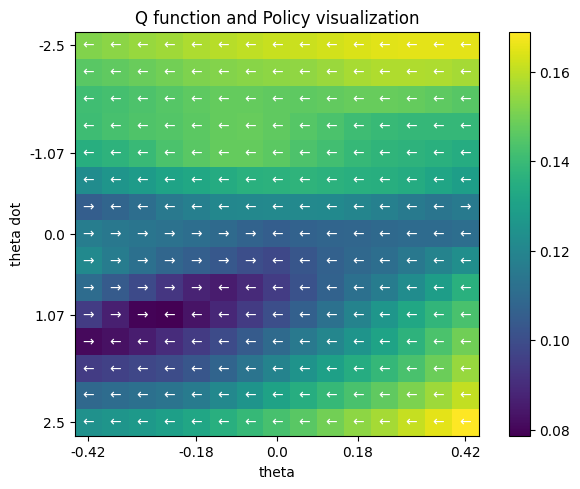

In [187]:
visualize_q_pi(model_batch)

#### Replay Buffer

In [188]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        """
        Parameters
        ----------
        capacity: int
            the length of your buffer
        """
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        batch_size: int
        """
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

#### Compute TD loss
This need an update now, since instead of working directly with the latest transition, we will now be sampling a batch of transitions from the buffer and learning from that.
<br>

**NOTE** Now since it's a batch operation you have added an extra axis and you'll have operations in different axis.

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [189]:
def compute_td_loss_batch(batch_size):
    """
    Parameters
    ----------
    batch_size: int
    
    Returns
    -------
    loss: tensor
    """
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = Variable(torch.FloatTensor(np.float32(state)))
    
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
        
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))
    
    # DONE: predict q_values. 
    # Hint:- remember it's a batch prediction so there will be extra dimension.
    q_values = model_batch.forward(state)
    
    # DONE: predict next state's q_values.
    next_q_values = model_batch.forward(next_state)

    # some checks for me to make sure I'm doing the right thing
    # print("q_values", q_values)
    # print("next_q_values", next_q_values)
    # print("action", action)
    # print("action.unsqueeze(1)", action.unsqueeze(1))
    # print("q_values.gather(1, action.unsqueeze(1))", q_values.gather(1, action.unsqueeze(1)))
    # print("q_values.gather(1, action.unsqueeze(1)).squeeze(1)", q_values.gather(1, action.unsqueeze(1)).squeeze(1))
    
    # DONE: get the q_values based on actions you took.
    #Hint:- the logic should be same as previous one but remember there is an extra dimension.
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value = next_q_values.max(1)[0]
        
    # DONE: calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # DONE: calculate MSE
    loss = F.mse_loss(q_value, expected_q_value.detach())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

As mentioned previously, DQN itself is not stable but we stablise it by multiple methods. Replay buffer is one of them. <br>
If your performance of DQN with replay buffer is same as previous, Try running it couple of times

<span style="color:blue"> **TODO** </span> Simply run the cell.

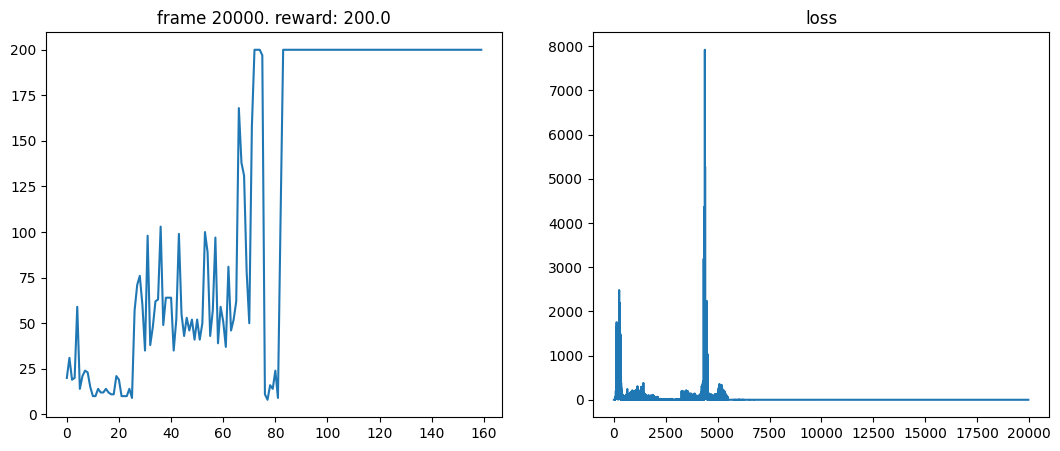

In [190]:
# Reinit
model_batch = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model_batch = model_batch.cuda()
    
optimizer = optim.Adam(model_batch.parameters())

num_frames = 20000
batch_size = 32
gamma      = 0.99
replay_buffer = ReplayBuffer(1000)
losses = []
all_rewards = []
episode_reward = 0
count = 0
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model_batch.act(state, epsilon)
    next_state, reward, done, info = env.step(action)
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_batch(batch_size)
        loss = loss.data.numpy().tolist()
        losses.append(loss)
        2,0
    if frame_idx % 200 == 0:
        count = plot(frame_idx, all_rewards, losses)

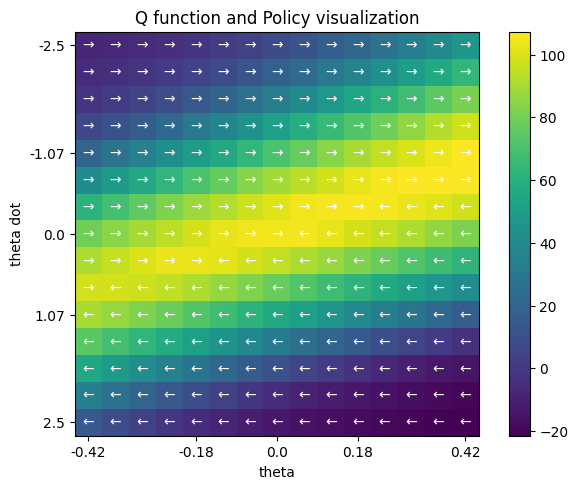

In [191]:
visualize_q_pi(model_batch)

<span style="color:red"> **TODO** </span>  Interpret briefly your results.

Here, we use the replay buffer. Although there are a very small number of spikes in the loss, now it is generally much lower and more stable (because we use batches and don't look only at the most recent experiences/same episode). The reward increases much faster and once reached, stays stable at the high value (of 200). The results in general are better than before.


### 1.3. DQN with target network

We saw in the *Deep Q Learning* that, when we want to calculate the TD error (aka the loss), we calculate the difference between the TD target (Q_target) and the current Q value (estimation of Q). <br>

But **we don’t have any idea of the real TD target**. We need to estimate it. Using the **Bellman equation**, we saw that the TD target is just the reward of taking that action at that state plus the discounted highest Q value for the next state. <br>

However, the problem is that we using the same parameters (weights) for estimating the target and the Q value. As a consequence, there is a big correlation between the TD target and the parameters (w) we are changing.

Therefore, it means that at every step of training, our Q values shift but also the target value shifts. So, we’re getting closer to our target but the target is also moving. It’s like chasing a moving target! This lead to a big oscillation in training.

To avoid this oscillation instead, we can use the idea of fixed Q-targets:

> * Using a separate network with a fixed parameter (we'll call it Target network) for estimating the TD target. <br>
while we train our DQN network.
> * After some number of steps, we copy the parameters from our DQN network to update the target network.

We’ll have more stable learning because the target function stays fixed for a while.

In current implementation you won't be using Replay buffer, just *Target network*.

In [192]:
current_model_target = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_target  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_target = current_model_target.cuda()
    target_model_target  = target_model_target.cuda()
    

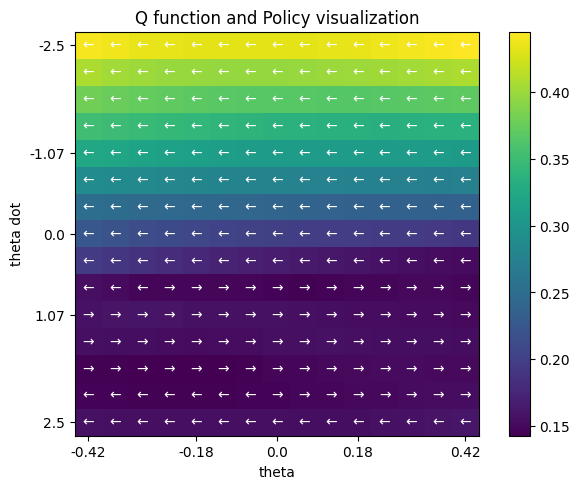

In [193]:
visualize_q_pi(current_model_target)

#### Sync model

In [194]:
def update_target(current_model, target_model):
    """
    Parameters
    ----------
    current_model: model
    
    target_model: model
    """
    target_model.load_state_dict(current_model.state_dict())

In [195]:
update_target(current_model_target, target_model_target)

#### Compute TD loss

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [196]:
def compute_td_loss_target(state, action, reward, next_state, done):
    
    state = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action  = Variable(torch.from_numpy(np.array(action)))
    reward  = Variable(torch.from_numpy(np.array(reward))).float()
    done = Variable(torch.from_numpy(np.array(int(done))))
    
    # DONE:- predict q_values.
    q_values = current_model_target.forward(state)
    
    # DONE:- predict next state's q_values based on target.
    next_q_values = target_model_target.forward(next_state)
    
    # DONE:- Get q-values for actions agent took.
    q_value = q_values[action.item()]
    
    # DONE:- gather next q_values of target model.
    # Hint:- next_q_values = next_q_state_values[maximum of next_q_values]
    next_q_value = next_q_values.max(0)[0]
    
    # DONE:- calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    # DONE:- MSE
    loss = F.mse_loss(q_value, expected_q_value.detach())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

<span style="color:blue"> **TODO** </span> Simply run the cell.

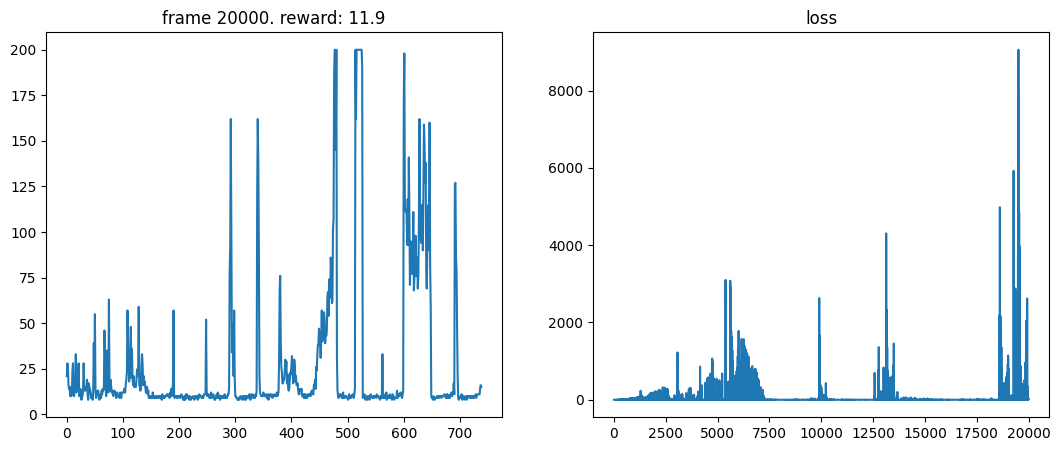

In [197]:
# Reinitialization
current_model_target = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_target  = DQN(env.observation_space.shape[0], env.action_space.n)
update_target(current_model_target, target_model_target)
if USE_CUDA:
    current_model_target = current_model_target.cuda()
    target_model_target  = target_model_target.cuda()
    
optimizer = optim.Adam(current_model_target.parameters())

# Run
num_frames = 20000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_target.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
            
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        loss = compute_td_loss_target(state, action, reward, next_state, done)
        losses.append(loss.data)

    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0    
    
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_target, target_model_target)
        

<span style="color:red"> **TODO** </span>  Interpret briefly your results.

Here, we make use of a target network (for fixed Q-targets), but we didn't use a replay buffer. The results, because of this, are rather bad in general. Although we can see that the reward reaches the high value (200) often, it fluctuates a lot because of exploration and the loss is very high on these fluctuation points. We can see that this technique is promising though (see later where we combine it with the replay buffer).


-------

### 1.4. DQN with target network and Replay buffer

Let's combine target network and Replay buffer.

#### Compute TD loss

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [198]:
def compute_td_loss_target_batch(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    # Hint:- most of the operations should be similar to previous impletations.
    
    # DONE:- predict q_values.
    q_values = current_model_dqn.forward(state) # current/target_model_dqn only declared in the next cell?
    
    # DONE:- predict next states's q_values based on target.
    next_q_values = target_model_dqn.forward(next_state)
    
    # DONE:- Get q-values for actions agent took.
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # DONE:- gather maximum of next q_values  
    next_q_value = next_q_values.max(1)[0] 
    
    # DONE:- calculate expected q value based on bellman eq.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
      
    # DONE MSE
    loss = F.mse_loss(q_value, expected_q_value.detach())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss


<span style="color:blue"> **TODO** </span> Simply run the cell. Notice the Reinitialization at the start! Same usage as `reset` from previous labs.

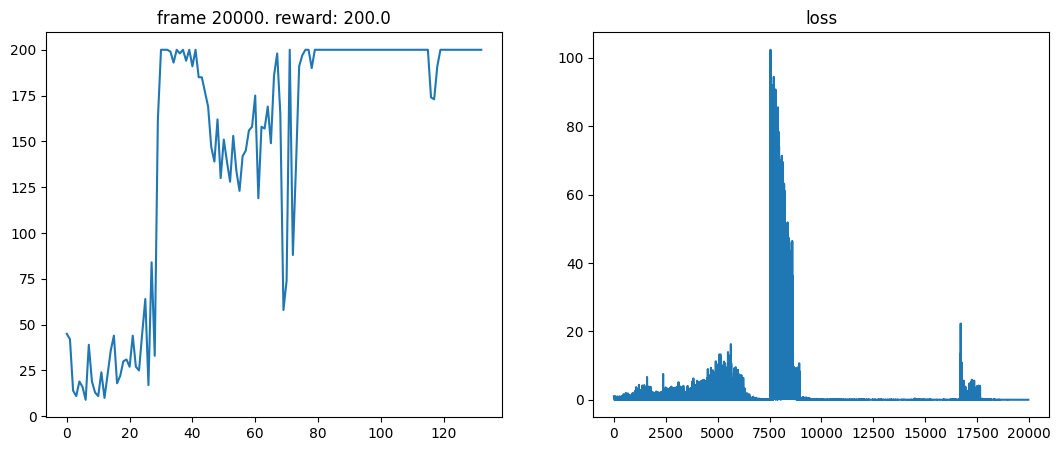

In [199]:
# Reinitialization
current_model_dqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_dqn  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_dqn = current_model_dqn.cuda()
    target_model_dqn  = target_model_dqn.cuda()
    
optimizer = optim.Adam(current_model_dqn.parameters())
update_target(current_model_dqn, target_model_dqn)
replay_buffer = ReplayBuffer(1000)

# Run
num_frames = 20000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_dqn.act(state, epsilon)
    next_state, reward, done, info = env.step(action)
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_target_batch(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_dqn, target_model_dqn)

<span style="color:red"> **TODO** </span>  Interpret briefly your results.

Here, we combine the target network and the replay buffer techniques. The results are much better, the reward reaches the high point more quickly and although there are still a few fluctuations, they are not as big and bad as before (we have a low overall loss (the loss values here are much much smaller than before)). 

## 2. <span style="color:green"> (3 points) </span> Improvements on DQN

### 2.1. Double DQN

The target based DQN in early stages is naive, we use the action that maximizes the Q-value[next_state]. But in the early stage, this is a noisy approximation so we tend to overestimate the Q-value.

To overcome the overestimation problem we can use both the networks the local and target as we have two sets of weights, so we can cross-validate it with both sets of weights and minimize the overestimation problem.


In [200]:
current_model_ddqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_ddqn  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_ddqn = current_model_ddqn.cuda()
    target_model_ddqn  = target_model_ddqn.cuda()
    
optimizer = optim.Adam(current_model_ddqn.parameters())
update_target(current_model_ddqn, target_model_ddqn)
replay_buffer = ReplayBuffer(1000)

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [201]:
def compute_td_loss_doubleDQN(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = Variable(torch.FloatTensor(np.float32(state)))
    with torch.no_grad():
        next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))
    
    # DONE:- predict current model
    q_values = current_model_ddqn.forward(state)
    
    # DONE:- predict next value from current model
    next_q_values = current_model_ddqn.forward(next_state)
    
    # DONE:- predict next state values from target model
    next_q_target_values = target_model_ddqn.forward(next_state)
    
    # Gather only values based on action
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # DONE:- calculate next state q_values that are not over estimated
    # Hint:- next_q_value = next state q-values from target[maximum of next state q-values from current model]
    next_q_value = next_q_target_values.gather(1, next_q_values.max(1)[1].unsqueeze(1)).squeeze(1)
    
    # DONE:- calculate expected Q-values of future
    expected_q_value = reward + gamma * next_q_value * (1 - done)
      
    # DONE:- apply MSE
    loss = F.mse_loss(q_value, expected_q_value.detach())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

<span style="color:blue"> **TODO** </span> Simply run the cell.

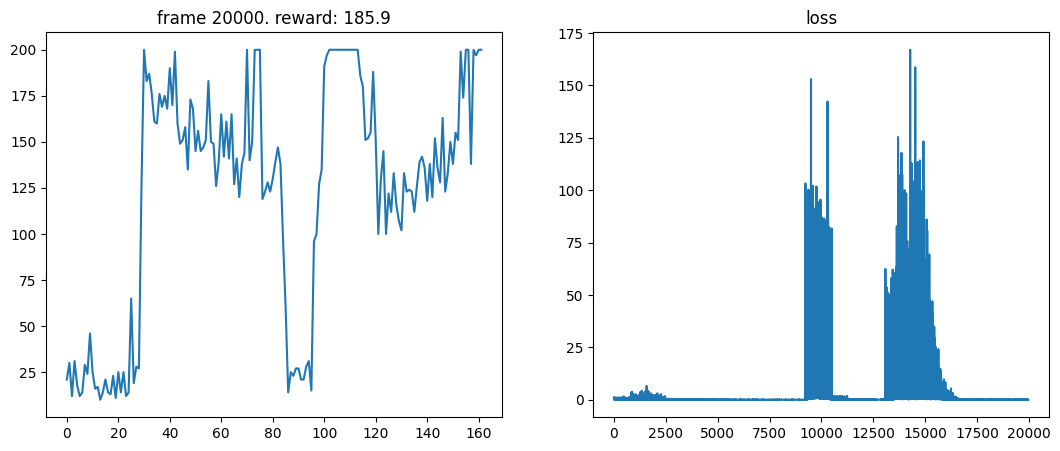

In [202]:
current_model_ddqn = DQN(env.observation_space.shape[0], env.action_space.n)
target_model_ddqn  = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_ddqn = current_model_ddqn.cuda()
    target_model_ddqn  = target_model_ddqn.cuda()
    
optimizer = optim.Adam(current_model_ddqn.parameters())
update_target(current_model_ddqn, target_model_ddqn)
replay_buffer = ReplayBuffer(1000)

num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_ddqn.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_doubleDQN(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_ddqn, target_model_ddqn)

<span style="color:red"> **TODO** </span>  Interpret briefly your results.


-----

### 2.2. Dueling Deep Q Networks
The key motivation behind this Dueling-DQN is that, for some problem statements, it is unnecessary to know the value of each action at every timestep. 
A simple example is of the Atari game Enduro, where it is not necessary to know which action to take until collision is imminent.

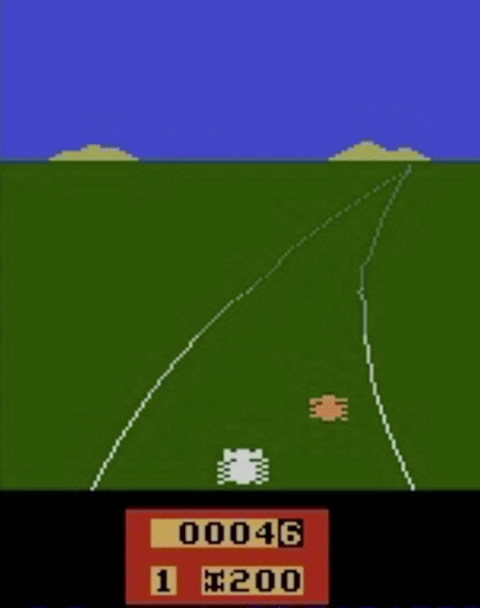

##### Architecture
Like the standard DQN architecture, we have layers to process data. From there, we split the network into two separate streams, one for estimating the state-value and the other for estimating state-dependent action advantages. After the two streams, the last module of the network combines the state-value and advantage outputs.


In [203]:
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        self.num_actions = num_outputs
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(state).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].numpy().tolist()
        else:
            action = random.randrange(self.num_actions)
        return action

In [204]:
current_model_dueldqn = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
target_model_dueldqn  = DuelingDQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    current_model_dueldqn = current_model_dueldqn.cuda()
    target_model_dueldqn  = target_model_dueldqn.cuda()
    
optimizer = optim.Adam(current_model_dueldqn.parameters())

replay_buffer = ReplayBuffer(1000)

#### Synchronize current policy net and target net

In [205]:
update_target(current_model_dueldqn, target_model_dueldqn)

<span style="color:blue"> **TODO** </span> Fill in TODOs in code, hints are provided to help you with code.

In [206]:
def compute_td_loss_duelingDQN(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)))
    action = Variable(torch.LongTensor(action))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))
    
    # DONE: Predict q_values from current model
    q_values = current_model_dueldqn.forward(state)
    
    # DONE: Predict q_values from target model
    next_q_values = target_model_dueldqn.forward(next_state)
    
    # DONE: get q_value based on action from q_values
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # DONE: find maximum of next_q_values 
    # Hint: keep in mind its a batch process so find maximum in correct axis
    next_q_value = next_q_values.max(1)[0]
    
    # DONE: calculate expected_q_value derived from bellman eq.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # DONE: calculate MSE between q_value and expected_q_value
    loss = F.mse_loss(q_value, expected_q_value.detach())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

<span style="color:blue"> **TODO** </span> Simply run the cell.

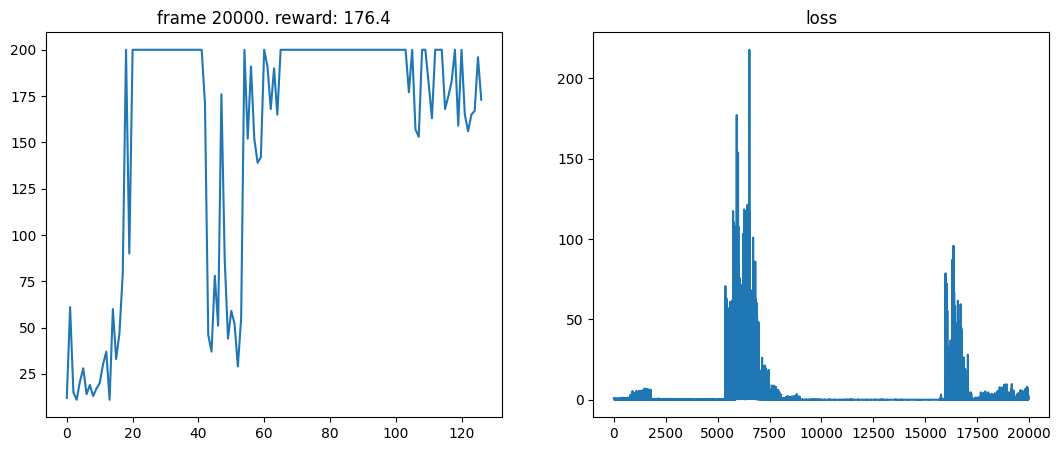

In [207]:
current_model_dueldqn = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
target_model_dueldqn  = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
update_target(current_model_dueldqn, target_model_dueldqn)
if USE_CUDA:
    current_model_dueldqn = current_model_dueldqn.cuda()
    target_model_dueldqn  = target_model_dueldqn.cuda()
    
optimizer = optim.Adam(current_model_dueldqn.parameters())
replay_buffer = ReplayBuffer(1000)

num_frames = 20000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model_dueldqn.act(state, epsilon)
    
    next_state, reward, done, info = env.step(action)
    if not 'TimeLimit.truncated' in info.keys() or not info['TimeLimit.truncated']:
        replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss_duelingDQN(batch_size)
        losses.append(loss.data)
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 100 == 0:
        update_target(current_model_dueldqn, target_model_dueldqn)

<span style="color:red"> **TODO** </span>  Interpret briefly your results.


-------

## <span style="color:green"> Bonus: Playing atari Pong. </span>

You have successfully completed the DQN, Now we'll step up the complexity of our **Environment**. <br>
With Complex visual environment like *Space invaders*, We'll need to include following steps:
* Pre-process the input
* Make our NN more complex
> * Pre-process the input: To reduce the complexity of our states, to reduce the computation time needed for training and thus to keep network shallow we pre-process each state(frame) to convert it from RGB to grey scale. By doing this we reduce the 3 color channels (RGB) to 1 Grey. 
then we crop the top of frame where we see the score for 2 reasons
    * Score doesn't matter as we are getting reward from env, thus it's just something we don't need.
    * Score keeps on changing which introduces extra complexity adds more number of states. A small change in pixels potentially means new state
> * Make our NN more complex: We introduce CNNs to preprocess the information from states(frames). You can further read on internet the advantages of CNNs over Fully connected layer. It's out of scope for this lab session.

The new architecture will look something like this:-

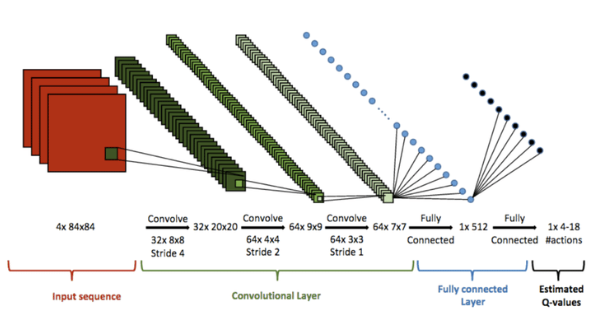

This may seem complex but it's really not. we'll walk through step by step.

1) Preprocess frame

2) stack 4 frames: We stack frame to limit the problem of temporal limitation. 
  >* Temporal limitation: By looking at following image can you tell if the ball in the game of pong going left or right?
    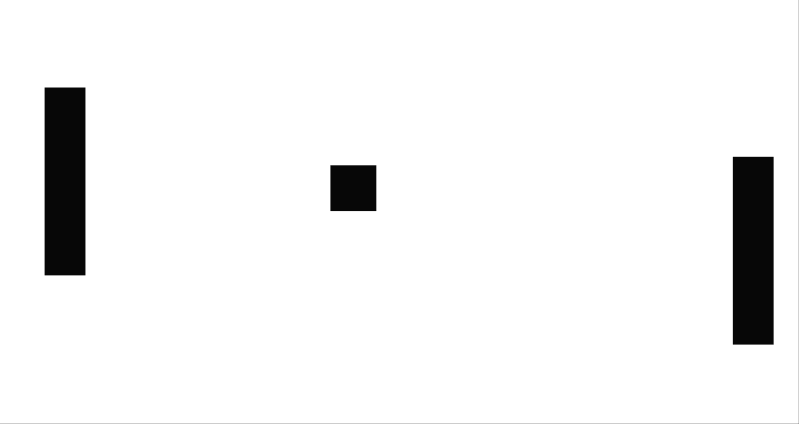 <br>
    Thus we stack 4 frames to get context. If it's going left or right.

3) Stack CNN layers.

The above presented architecture is just an example. The complexity of your network depends on the Environment.

Different environment have different scoring system. For example, in Pong, players can get 1 point when wining the play. Otherwise, players get -1 point. However, in SpaceInvaders, players get 10~30 points when defeating invaders. This difference would make training unstable. Thus Clipping Rewards technique clips scores, which all positive rewards are set +1 and all negative rewards are set -1.
To avoid having different architectures to play different games we often **clip rewards**.

In [208]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

In [209]:
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

In [210]:
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

In [211]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

In [212]:
class PreProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, cfg):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = cfg.frame_width
        self.height = cfg.frame_height
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]


In [213]:
class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)


def convert_pytorch(env):
    return ImageToPyTorch(env)

In [214]:
def wrap_env(env, cfg,clip_rewards=True, frame_stack=True, scale=True):
    """Configure environment for DeepMind-style Atari.
    """
    env = PreProcessFrame(env, cfg)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, cfg.frame_number)
    return env

In [215]:
class Config:
    """Config for environment"""
    def __init__(self):
        self.frame_number = 4
        self.frame_width = 84
        self.frame_height = 84
        
    def __setitem__(self, key, value):
        return setattr(self, key, value)

In [216]:
env_id = "PongNoFrameskip-v4"
config = Config()

In [217]:
class Environment:
    def __init__(self, env_id, config):
        self.env = gym.make(env_id)
        self.env = wrap_env(self.env, config)
        self.env = convert_pytorch(self.env)
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space
        self.spec = self.env.spec
        self.states = None

    def reset(self):
        self.states = self.env.reset()
        return self.states

    def step(self, a):
        self.states, r, done, info = self.env.step(a)
        return self.states, r, done, info

    def render(self):
        self.env.render()

    def close(self):
        self.env.close()

<span style="color:blue"> **TODO** </span> Based on Lab 6 intuition decide on width of each layer.
replace "+" values in **CnnDQN Constructor**

In [218]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32 , kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0))
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data
        else:
            action = random.randrange(env.action_space.n)
        return action

In [219]:
env = Environment(env_id=env_id, config=config)
current_model = CnnDQN(env.observation_space.shape, env.action_space.n)
target_model  = CnnDQN(env.observation_space.shape, env.action_space.n)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)

replay_initial = 1000
replay_buffer = ReplayBuffer(10000)

update_target(current_model, target_model)

FileNotFoundError: Could not find module 'C:\Users\centu\PycharmProjects\RL\venv\Lib\site-packages\atari_py\ale_interface\ale_c.dll' (or one of its dependencies). Try using the full path with constructor syntax.

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

<span style="color:blue"> **TODO** </span> Based on different td_loss functions you have worked with write a td_loss function. 

<span style="color:red"> **TODO** </span> Justify why you chose, whichever TD loss function you chose?

In [ ]:
num_frames = 1000000
batch_size = 64
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

import time
init = time.time()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        # TODO:- Based on Td_loss functions you have worked with write or
        # choose a function to reuse here and justify your choice
        loss = 
        losses.append(loss.data)
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)
        print("Time: {}".format(time.time() - init))
        
    if frame_idx % 1000 == 0:
        update_target(current_model, target_model)